In [11]:
% reset -f

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.cross_validation import StratifiedKFold, cross_val_score

from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score

from imblearn.under_sampling import RandomUnderSampler

from IPython.display import display

In [12]:
df = pd.read_csv('dataSets/pima_indians_diabetes.csv')

#  if the dataset is pre-indexed, remove the indexing
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis = 1) 
    print 'Column Dropped'

# if the target variable, y, is not binarized (i.e. [0,1]), then binarize it
labBin = LabelBinarizer()
df['y'] = labBin.fit_transform(df['y'])
dp = pd.get_dummies(df)
X = dp.drop('y', axis = 1)
y = dp[['y']]

# get the features
theFeatures = X.columns

# convert the dataframes to arrays
X = X.values
y = y.values
y.shape = np.shape(y)[0]

yOrig = y[:] # need this later for plotting feature impacts

# and carry out feature scaling
X = StandardScaler().fit_transform(X)

# check and confirm data dimension and label skewness
print 'The dimensions of X and y are:', [np.shape(X), np.shape(y)], '\n'

labelProportions = []

for j in set(y):
    thisLabelProportion = 100.0*sum(y==j)/y.shape[0]
    labelProportions.append(thisLabelProportion)
    print 'Proportion of Label ' + str(j) + ':', thisLabelProportion, 'percent'

The dimensions of X and y are: [(768L, 8L), (768L,)] 

Proportion of Label 0: 65.1041666667 percent
Proportion of Label 1: 34.8958333333 percent


In [13]:
isBalanced = 1 # this variable indicates whether or not the classes are balanced

if np.min(labelProportions) < (100./4.):
    isBalanced = 0
    rus = RandomUnderSampler()
    X, y = rus.fit_sample(X, y)

if isBalanced == 0:
    print 'The label was undersampled.\nThe new dimensions of X and y are now:', [np.shape(X), np.shape(y)], '\n'
else:
    print 'The dataset is sufficiently balanced.\nThe dimensions of X and y are still:', [np.shape(X), np.shape(y)], '\n'

labelProportions = []

for j in set(y):
    thisLabelProportion = 100.0*sum(y==j)/y.shape[0]
    labelProportions.append(thisLabelProportion)
    print 'Proportion of Label ' + str(j) + ':', thisLabelProportion, 'percent'

The dataset is sufficiently balanced.
The dimensions of X and y are still: [(768L, 8L), (768L,)] 

Proportion of Label 0: 65.1041666667 percent
Proportion of Label 1: 34.8958333333 percent


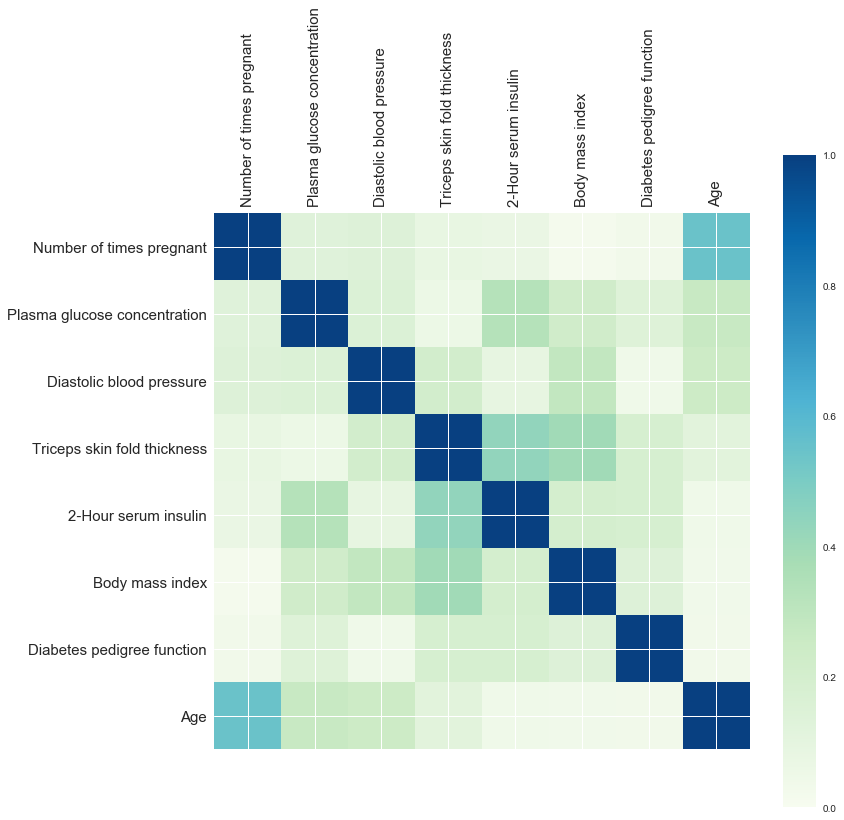

In [14]:
# plot correlation matrix

dff = dp.drop('y', axis=1)

# NOTE: use absolute values of the correlations (i.e. [0,1] instead of [-1,1])
#       this makes it easier to view at a glance
correlations = abs(dff.corr()) # absolute values of the correlations (i.e. [0,1] instead of [-1,1])

# display(correlations)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=0, vmax=1, cmap='GnBu')
fig.colorbar(cax)
ticks = np.arange(0,len(dff.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(dff.columns, rotation = 90, fontsize=15)
ax.set_yticklabels(dff.columns, fontsize=15)
plt.show()

In [15]:
# Create regularization strength space
cList = []
for k in [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]:
    for j in [1,1.25,2.5,3.75,5,6.25,7.5,8.75]:
        cList.append(j*k)
        
# Create regularization penalty space
penalty = ['l1', 'l2']

# instantiate a Logistic Regression model to run the random search on
thisModel = LogisticRegression()

# Create hyperparameter options
hyperparameters = dict(C=cList, penalty=penalty)

# run a grid search for hyperparameter tuning
searchModel = GridSearchCV(thisModel, hyperparameters, cv=5, verbose=1)
best_model = searchModel.fit(X, y)

# just out of curiosity, what was the result of the hyperparameter tuning
bestPen = best_model.best_estimator_.get_params()['penalty']
bestReg = best_model.best_estimator_.get_params()['C']
print 'Best Penalty:', bestPen
print 'Best C:', bestReg

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Penalty: l2
Best C: 0.25


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    3.2s finished


In [16]:
# select optimal number of features
rfecv = RFECV(estimator=thisModel, step=1, cv=StratifiedKFold(y, n_folds=5), scoring='roc_auc')
Xt = rfecv.fit_transform(X, y)
optimalNumberOfFeatures = rfecv.n_features_
print 'Optimal Number of Features: ', optimalNumberOfFeatures

Optimal Number of Features:  8


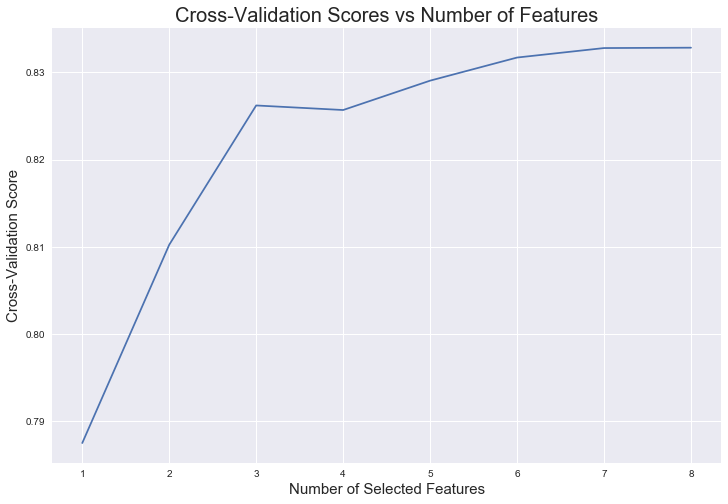

In [17]:
# Plot number of selected features VS cross-validation scores
plt.figure(figsize=[12,8])
plt.xlabel("Number of Selected Features", fontsize=15)
plt.ylabel("Cross-Validation Score", fontsize=15)
plt.title("Cross-Validation Scores vs Number of Features", fontsize=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xticks(range(1, len(rfecv.grid_scores_) + 1))
plt.show()

In [18]:
# get the feature feature importance rankings
model = RandomForestClassifier(n_estimators=300)
model.fit(Xt,y) 
theImportances = list(model.feature_importances_)
sortedImportances = sorted(theImportances,reverse = True)

print
print 'Top ', optimalNumberOfFeatures, ' Features:\n'
for ii in range(1,optimalNumberOfFeatures+1):
    print theFeatures[theImportances.index(sortedImportances[ii-1])], sortedImportances[ii-1], ii

print
print 'Number of selected features: ', optimalNumberOfFeatures
print


Top  8  Features:

Plasma glucose concentration 0.25862934118896114 1
Body mass index 0.16610065021825898 2
Age 0.13762659973314786 3
Diabetes pedigree function 0.12788480057397889 4
Diastolic blood pressure 0.0865939403564474 5
Number of times pregnant 0.08303947917851233 6
2-Hour serum insulin 0.07160125340878873 7
Triceps skin fold thickness 0.06852393534190471 8

Number of selected features:  8



In [19]:
# Compare models to see how they perform relative to each other

# 1. Compare them using entire dataset

theModels = {'Logistic':LogisticRegression(penalty=bestPen, C=bestReg), 'LDA':LinearDiscriminantAnalysis(), 'SVM':SVC(C=1, kernel='rbf'), 'Rand Forest':RandomForestClassifier(n_estimators=300)}
    
for aModel in theModels:
    model = theModels[aModel]
    results = cross_val_score(model, X, y, scoring='roc_auc', cv=StratifiedKFold(y, n_folds=3)) # results of the k-fold cross-validations
    print aModel+':\t ', (np.mean(results))

Rand Forest:	  0.8302630813760173
LDA:	  0.831780798615155
SVM:	  0.8327768781435969
Logistic:	  0.8329176642128105


In [20]:
# Compare models to see how they perform relative to each other

# 2. Compare them with dataset containing only the selected features

theModels = {'Logistic':LogisticRegression(penalty=bestPen, C=bestReg), 'LDA':LinearDiscriminantAnalysis(), 'SVM':SVC(C=1, kernel='rbf'), 'Rand Forest':RandomForestClassifier(n_estimators=300)}
    
for aModel in theModels:
    model = theModels[aModel]
    results = cross_val_score(model, Xt, y, scoring='roc_auc', cv=StratifiedKFold(y, n_folds=3)) # results of the k-fold cross-validations
    print aModel+':\t ', (np.mean(results))

Rand Forest:	  0.8306461727208158
LDA:	  0.831780798615155
SVM:	  0.8327768781435969
Logistic:	  0.8329176642128105


<font face="mistral" size=6 color=blue>
<center>
The performance on the reduced dataset should be comparable with, if not better than, that on the entire dataset
</center>
</font>